# Project: Wrangling And Analyzing Twitter Data


**Table of Contents**

- [Introduction](#introduction)
- [Data Wrangling](#data_wrangling)
    - [Gathering Data](#gathering_data)
    - [Assessing Data](#assessing_data)
    - [Cleaning Data](#cleaning_data)
    - [Storing Data](#storing_data)
- [Analysis](#analysis) 
    - [Research Question 1](#research_question_1)
    - [Research Question 2](#research_question_2)
    - [Research Question 3](#research_question_3)
- [Conclusion](#conclusion)

<a id='introduction'></a>

# Introduction

This project concentrates on wrangling and analyzing tweet data of the Twitter account [\@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). This account has more than 8.7 Million followers. (As of June 2, 2020) WeRateDogs is dedicated to rate people’s dogs. The secrets behind popularity of WeRateDogs are, their ratings and funny comments they write about dogs they rate.

<img src='images/Profile_of_WeRateDogs.png' alt='Profile of WeRateDogs' />

In most cases, their ratings have a denominator of 10; but, the numerators almost always are greater than 10. You may be wondering how much funny their comments are, See the figure below.

<a id='sample_tweet_by_WeRateDogs'></a>

<img src='images/Sample_tweet_by_WeRateDogs.png' alt='Sample tweet by WeRateDogs' />

Goal of this project is to wrangle and analyze tweet data of WeRateDogs. The wrangling process involved finding, fixing, and documenting quality and tidiness issues. On the other hand; outcome of the analysis phase was, three interesting findings about WeRateDogs.


In [1]:
# Import libraries
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer

%matplotlib inline
# Set to this value to read the truncated texts from twitter_archive
pd.set_option('max_colwidth', 800)


<a id='data_wrangling'></a>
    
# Data Wrangling

In the wrangling process three main operations were performed. First; downloading the tweeter data and predictions of dog breeds. Second, assessing the data for quality and tidiness issues. Finally; creating a master dataset which was used in the analysis phase.

<a id='gathering_data'/></a>

## Gathering Data

In this project, gathering data involved:

- Manually downloading WeRateDogs’ Twitter archive,

- Programmatically downloading missing properties using [Twitter’s API for Python](http://docs.tweepy.org/en/stable/), and

- Programmatically downloading image predictions using [Requests](https://requests.readthedocs.io/en/master/).


In [2]:
# Read the WeRateDogs archive
twitter_archive = pd.read_csv('data/twitter-archive-enhanced.csv')

In [3]:
# Programmatically download image predictions using Requests. 
# And save them to a file.
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name_tsv = url.split('/')[-1]
try:
    response = requests.get(url)
    print('File downloaded successfully!')
    
    with open(os.path.join('data/', file_name_tsv), 'wb') as file:
        file.write(response.content)
    print('File written successfully!')
    
    # Read data from the downloaded file 
    image_predictions = pd.read_csv('data/image-predictions.tsv', '\t')
except requests.ConnectionError:
    print('Failed to establish a new connection!')
except IOError:
    print('Failed to write to a file!')

File downloaded successfully!
File written successfully!


In [ ]:
# Programmatically download missing tweet properties using API.

# Setup authentication handler
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor.

# Instantiate the Twitter API
api = tweepy.API(auth_handler= auth, wait_on_rate_limit=True)
tweet_ids = twitter_archive.tweet_id
file_name_txt = 'tweet-json.txt'
correct_id_count, failed_id_count = (0, 0)
start_time = timer()

# Query Twitter using its API and,
# Write the response object to a text file
with open(os.path.join('data/', file_name_txt), 'wb') as file:
    for tweet_id in tweet_ids:
        try:
            json.dump(api.get_status(tweet_id, tweet_mode='extended'), file)
            correct_id_count += 1
            print('Fetched Id {0}: {1}'.format(correct_id_count, str(tweet_id)))
        except tweepy.TweepError:
            failed_id_count += 1
            print('Failed Id {0}: {1}'.format(failed_id_count, str(tweet_id)))
            continue

end_time = timer()
print('Execution time: {0:.2f}s.'.format(end_time - start_time))

In [4]:
# Read data from the text file line by line and,
# Create a dataframe using this data
tweet_data = {'tweet_id': [], 'retweet_count': [], 'favorite_count': [], 'retweet': []}
try:
    with open('data/tweet-json.txt', 'r') as file:
        for line in file:
            tweet = json.loads(line)
            tweet_data['tweet_id'].append(tweet['id_str'])
            tweet_data['retweet_count'].append(tweet['retweet_count'])
            tweet_data['favorite_count'].append(tweet['favorite_count'])
            try:
                # The retweet text in its truncated form will be returned if
                # the tweet is actually a retweet
                retweet_checker = tweet['retweeted_status']
                tweet_data['retweet'].append(True)
            except KeyError:
                # The tweet is not a retweet 
                tweet_data['retweet'].append(False)
    
    print('File red successfully!')
    tweet_json = pd.DataFrame(tweet_data)
except FileNotFoundError:
    print('Failed to read from a file!')

File red successfully!



<a id='assessing_data'/></a>

## Assessing Data

The process of finding problems from the collected data involved the use of visual and programmatic techniques. The goal was to detect and document at least 8 quality and 2 tidiness issues. Quality issues found at this stage were grouped in to completeness, validity, accuracy, and consistency categories.

### Quality Issues in the Twitter Archive

- Invalid column datatypes.

    - Id columns (such as tweet_id, and in_reply_to_status_id) were int and float instead of string.
    
    - Timestamp columns (such as timestamp and retweeted_status_timestamp) were string instead of datetime.

- Inconsistent and inaccurate dog names.

    - Some dog names (such as ‘a’, and ‘such’) were in lowercase, while others were in uppercase.
    
    - All lowercase names were inappropriate.

    - Few names (such as O’Malley and Al Cabone) were represented by their beginning characters.

- Inaccurate dog stages.

    - Null dog stages were represented using the string None instead of Python’s None.
    
    - In some tweets, multiple stages were used to represent a single dog. 

- Inaccurate ratings.

    - Notations (such as 24/7, 9/11, 7/11, 4/20 (April 20), and 11/15/15) in some tweets were wrongly considered as ratings,
    
    - Decimal rating (such as 9.75, 11.27, and 11.26) in some tweets were not correctly retrieved,

    - Some rating-like notations (such as 3 1/2, and 50/50) were wrongly considered as ratings.


In [5]:
# Using the Series.dtype to assess datatypes of columns.
print(twitter_archive.tweet_id.dtype)
print(twitter_archive.in_reply_to_status_id.dtype)
print(twitter_archive.in_reply_to_user_id.dtype)
print(twitter_archive.retweeted_status_id.dtype)
print(twitter_archive.retweeted_status_user_id.dtype)
print(twitter_archive.timestamp.dtype)
print(twitter_archive.retweeted_status_timestamp.dtype)

int64
float64
float64
float64
float64
object
object


In [7]:
# Get lowercase dog names, and extract unique ones.
display(twitter_archive[twitter_archive.name.str.islower() == True
                       ].name.unique())

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [9]:
# Get short dog names that are not in lowercase.
short_names = twitter_archive[(twitter_archive.name.str.len() < 3) & 
                              (twitter_archive.name.str.islower() == False)
                             ]['name'].unique()

# From this list, names at 775 and 820 are inacurate.
display(twitter_archive[twitter_archive.name.isin(short_names)]
        [['text', 'name']].loc[np.r_[775, 820], :])

,text,name
775,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O
820,Meet Al Cabone. He's a gangsta puppa. Rather h*ckin ruthless. Shows no mercy sometimes. 11/10 pet w extreme caution https://t.co/OUwWbEKOUV,Al


In [10]:
# Get unique values that represent dog stages.
# Each represent null data as a string None.
display(twitter_archive.doggo.unique())
display(twitter_archive.floofer.unique())
display(twitter_archive.pupper.unique())
display(twitter_archive.puppo.unique())

array(['None', 'doggo'], dtype=object)

array(['None', 'floofer'], dtype=object)

array(['None', 'pupper'], dtype=object)

array(['None', 'puppo'], dtype=object)

In [11]:
# Get dogs with multiple assigned stage
multiple_dog_stage = ((((twitter_archive.doggo == 'doggo') & 
                        (twitter_archive.floofer == 'floofer')) | 
                      ((twitter_archive.pupper == 'pupper') & 
                       (twitter_archive.puppo == 'puppo'))) |
                      (((twitter_archive.doggo == 'doggo') | 
                        (twitter_archive.floofer == 'floofer')) & 
                      ((twitter_archive.pupper == 'pupper') | 
                       (twitter_archive.puppo == 'puppo'))))

display(twitter_archive[multiple_dog_stage][
    ['tweet_id', 'text', 'doggo', 'floofer', 'pupper', 'puppo']].head(2))

,tweet_id,text,doggo,floofer,pupper,puppo
191,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggo,None,None,puppo
200,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggo,floofer,None,None


In [16]:
# Get tweets with rating denominator < 10 and numerator > 17.
# Some of these rating_numerator/rating_denominator are inaccurate.
display(twitter_archive[twitter_archive.rating_denominator < 10]
        [['text', 'rating_numerator', 'rating_denominator']].tail(2))
display(twitter_archive[twitter_archive.rating_numerator > 17]
        [['text', 'rating_numerator', 'rating_denominator']]
        .loc[np.r_[340, 763], :])

,text,rating_numerator,rating_denominator
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


,text,rating_numerator,rating_denominator
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10



### Quality Issues in the Json Data

- 179 retweets, which are not useful, were extracted through the API.

- Inconsistent tweet id datatypes.

    - In tweet_json, tweet ids were represented as strings, but twitter_archive used int.

- Incomplete records.

    - Twitter archive had 2356 records, but tweet_json had 2354.


In [17]:
# Since only original tweets are usefull in our case,
# 179 of the retweets need to removed.
display(tweet_json.retweet.value_counts())

# Display a concise summary of a DataFrame.
# This summary shows that, tweet_id is represented using string
tweet_json.info()

# Display the difference in the number of observations.
len_twitter_archive = len(twitter_archive.tweet_id.unique())
len_tweet_json = len(tweet_json.tweet_id.unique())
print('\n'+
      'Length of twitter_archive is {0}, but tweet_json contains {1} records.'.
      format(len_twitter_archive, len_tweet_json))

False    2175
True      179
Name: retweet, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
retweet           2354 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 57.5+ KB

Length of twitter_archive is 2356, but tweet_json contains 2354 records.



### Quality Issues in the Json Data

- Inconsistent tweet id datatypes.

    - In tweet_json, tweet ids were represented as strings, but image_predictions used int.

- Incomplete records.

    - Twitter archive had 2356 records, but image_predictions had 2075.


In [18]:
# Display the datatype of tweet_id.
print(image_predictions.tweet_id.dtype)

# Display the difference in the number of observations.
len_image_predictions = len(image_predictions.tweet_id.unique())
print('\nLength of twitter_archive is {0}, but image_predictions contains {1} records.'.
      format(len_twitter_archive, len_image_predictions))

int64

Length of twitter_archive is 2356, but image_predictions contains 2075 records.



### Tidiness Issues

- Doggo, floofer, pupper, and puppo Variables could be converted to dog_stage variable.

- Tweet json and image_predictions could be merged with the twitter_archive.


In [19]:
# doggo, floofer, pupper, and puppo variables can be simplified to dog stage.
display(twitter_archive[['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo'
                        ]].head(2))

# retweet_count and favorite_count variables can be added to twitter_archive.
display(tweet_json.head(2))

# [p1, p2, p3] variables can be simplified to prediction, 
# [p1_conf, p2_conf, p3_conf] variables can be simplified to confidence, 
# [p1_dog, p2_dog, p3_dog] variables can be simplified to is_dog.
display(image_predictions[['tweet_id', 'p1', 'p1_conf', 'p1_dog', 
                           'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'
                          ]].head(2))

,tweet_id,doggo,floofer,pupper,puppo
0,892420643555336193,None,None,None,None
1,892177421306343426,None,None,None,None


,tweet_id,retweet_count,favorite_count,retweet
0,892420643555336193,8853,39467,False
1,892177421306343426,6514,33819,False


,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True



<a id='cleaning_data'></a>

## Cleaning Data

Fixing problems, which had been seen during the assessment stage, was started by making copies of the data. Then, each of the listed subsequent steps followed.

- Defining the plan for addressing the issues,

- Coding to fix the issues,

- Testing if the issues ware addressed properly, and

- Documenting the effort.


In [20]:
# Make a copy of the data
twitter_archive_copy = twitter_archive.copy()
tweet_json_copy = tweet_json.copy()
image_predictions_copy = image_predictions.copy()


### Quality Issues in the Twitter Archive

#### Define

- Apply `DataFrame.astype()` function on each of Id. variables to convert them to _string_.

- Apply `Pandas.to_datetime()` function on each of Timestamp variables.

#### Code


In [21]:
# Simple casting to int would not handle the nan,
# So use pandas INT64 datatype
twitter_archive = twitter_archive.astype({
    'tweet_id': str,
    'in_reply_to_status_id': str, 
    'in_reply_to_user_id': str,
    'retweeted_status_id': str,
    'retweeted_status_user_id': str})

# Convert timestamps into datetime
twitter_archive.timestamp = pd.to_datetime(twitter_archive.timestamp)
twitter_archive.retweeted_status_timestamp = pd.to_datetime(
    twitter_archive.retweeted_status_timestamp)


#### Test


In [22]:
# Datatype of id columns should be int64,
# Datatype of timestamp columns should be datetime64,
print(twitter_archive.tweet_id.dtype)
print(twitter_archive.in_reply_to_status_id.dtype)
print(twitter_archive.in_reply_to_user_id.dtype)
print(twitter_archive.retweeted_status_id.dtype)
print(twitter_archive.retweeted_status_user_id.dtype)
print(twitter_archive.timestamp.dtype)
print(twitter_archive.retweeted_status_timestamp.dtype)

object
object
object
object
object
datetime64[ns, UTC]
datetime64[ns, UTC]



#### Define

- Get lowercase names using `Series.str.islower()` and set to `None`.

- Assign O'Malley and Al Cabone to name at indices 775 and 820.

#### Code


In [23]:
# Remove lowercase names
mask = (twitter_archive.name.str.islower() == True)
twitter_archive.loc[mask, 'name'] = None

# Fix misspelled names
twitter_archive.iloc[np.r_[775, 820], 12] = "O\'Malley", "Al Cabone"


#### Test


In [24]:
# Number of rows with lowercase name should be 0
print(len(twitter_archive[twitter_archive.name.str.islower() == True]))

# Names at the specified indices should be O'Malley and Al Cabone
twitter_archive.iloc[np.r_[775, 820], 12]

0


775     O'Malley
820    Al Cabone
Name: name, dtype: object


#### Define

- Get rows where values of `doggo`, `floofer`, `pupper`, or `puppo` were 'None'; then set them to None.

- Get rows with indices 191, 200, 460, 575, and 705; then set the _invalid_ stages to None.

- Get rows with indices 531, 565, 733, 778, 822, 889, 956, 1063, and 1113; then set _doggo_ to *multiple_stages* and set _pupper_ to None.

#### Code


In [25]:
# Fix empty dog stages represented as a string None
twitter_archive.loc[twitter_archive.doggo == 'None', 'doggo'] = None
twitter_archive.loc[twitter_archive.floofer == 'None', 'floofer'] = None
twitter_archive.loc[twitter_archive.pupper == 'None', 'pupper'] = None
twitter_archive.loc[twitter_archive.puppo == 'None', 'puppo'] = None

# Fix multiple stages given for a single dog
# by setting the incorrect ones to None
twitter_archive.iloc[191, -4] = None
twitter_archive.iloc[200, -4] = None
twitter_archive.iloc[460, -2] = None
twitter_archive.iloc[575, -4] = None
twitter_archive.iloc[705, -2] = None

# For tweets mentioning multiple dogs, 
# the doggo stage was set to multiple_stages. 
# But, all other stages were set to None.
twitter_archive.iloc[np.r_[531, 565, 733, 778, 822, 889, 956, 1063, 1113], 
                     np.r_[-4, -2]] = 'multiple_stages', None


#### Test


In [26]:
# The number of non-null values in the last 4 columns
# should be less than 2356. This is because the string None
# is now converted to NULL.
twitter_archive.iloc[:, -4:].info()

# Value of doggo for the first two rows, 
# and also the forth row should be None.
# Value of pupper for the third and last rows should be None
print('\n', twitter_archive.iloc[np.r_[191, 200, 460, 575, 705],
                                 np.r_[-4, -2]])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
doggo      94 non-null object
floofer    10 non-null object
pupper     246 non-null object
puppo      30 non-null object
dtypes: object(4)
memory usage: 73.7+ KB

      doggo  pupper
191   None    None
200   None    None
460  doggo    None
575   None  pupper
705  doggo    None



#### Define

- Extract *rating_numerator* and *rating_denominator* from the *text* variable using **regular expression** in combinations with `Series.str.extractall()`.

- If a text contains multiple ratings, then consider the first as the correct value; then replace it with the appropriate vaues latter if needed.

- Fix inappropriate values using thier indices by setting them to None.

#### Code


In [27]:
# Fix issues associated with rating numerator and denominator

# Get all the possible ratings from a text using regual expressions
idx = pd.IndexSlice
all_numerators_vs_denominators = twitter_archive.text.str.extractall(
    r'(?P<rating_numerator>\d+(?:\.\d+)?)\/(?P<rating_denominator>\d+)')

# Assume all ratings that appeared first as correct ratings
first_rating = all_numerators_vs_denominators.loc[idx[:, 0], :]

# Get ratings that appeared second, these are the actual correct ratings, 
correct_ratings = all_numerators_vs_denominators.loc[idx[
    np.r_[313, 784, 1068, 1165, 1202, 2335], 1], :]

# Drop the added multi-level index
correct_ratings = correct_ratings.reset_index(level=1, drop=True)
first_rating = first_rating.reset_index(level=1, drop=True)

# Replace values that were assumed to be correct, but are not, 
# with the actual correct values
first_rating.iloc[correct_ratings.index, :] = correct_ratings

# Replace previous columns with the new ones
twitter_archive.iloc[:, np.r_[10, 11]] = first_rating

# Set incorrect values to null
twitter_archive.iloc[np.r_[342, 516], np.r_[10, 11]] = np.nan, np.nan

# Cast rating numerator and denominator to float
twitter_archive = twitter_archive.astype({
    'rating_numerator': float, 
    'rating_denominator': float})


#### Test


In [28]:
# If correct, these values should have correct values.
# Records at 342, 516 should have null values.
display(twitter_archive.iloc[np.r_[313, 1165, 2335, 784, 1068, 1202, 
                           340, 695, 1662, 763, 1712], np.r_[10, 11]])

display(twitter_archive.iloc[np.r_[342, 516], np.r_[10, 11]])

,rating_numerator,rating_denominator
313,13.00,10.0
1165,13.00,10.0
2335,9.00,10.0
784,14.00,10.0
1068,14.00,10.0
1202,11.00,10.0
340,9.75,10.0
695,9.75,10.0
1662,7.00,11.0
763,11.27,10.0


,rating_numerator,rating_denominator
342,NaN,NaN
516,NaN,NaN



#### Define

- Drop rows with null *rating_numerator* or *rating_denominator*, by selecting only non-null values.

#### Code


In [29]:
# Drop rows with NAN rating
twitter_archive = twitter_archive[twitter_archive.rating_numerator.notna() & 
                                  twitter_archive.rating_denominator.notna()]


#### Test


In [30]:
# The result should be 0
len(twitter_archive[twitter_archive.rating_numerator.isna() | 
                    twitter_archive.rating_denominator.isna()])

0


### Tidiness Issues

Before solving the quality issues in _tweet json_ and _image predictions_, lets focus on solving the **structural** issue of *twitter_archive*.

#### Define

- Convert *doggo*, *floofer*, *pupper*, and *puppo* into *dog_stage* using `DataFrame.melt()`.

- Since `DataFrame.melt()` creates multiple copies of each single row, drop duplicates by selecting non-duplicated records.

#### Code


In [31]:
# Make a copy of the twitter_archive data
test_twitter_archive = twitter_archive.copy()

# Melt the last 4 columns
twitter_archive = twitter_archive.melt(id_vars=twitter_archive.columns[:-4], 
                                       value_name='dog_stage')

# Drop the default variable created by the operation
twitter_archive.drop(columns='variable', inplace=True)

# Get records having a value for dog_stage
# These records have no duplication within them
dog_stage_data = twitter_archive[(twitter_archive.dog_stage.isna() == False)]

# Get records with a None value for dog_stage, and
# Having a different tweet_id than those in dog_stage_data
dog_stage_None_data = twitter_archive[(
    twitter_archive.dog_stage.isna() == True) & 
    (twitter_archive.tweet_id.isin(dog_stage_data.tweet_id) == False)]

# Drop any duplication from dog_stage_None_data
dog_stage_None_data = dog_stage_None_data[
    dog_stage_None_data.tweet_id.duplicated() == False]

# Concatenate dog_stage_None_data and dog_stage_data
twitter_archive = dog_stage_None_data.append(dog_stage_data)


#### Test


In [32]:
# If correct, sum of non-null values in the last 4 columns 
# of test_twitter_archive will be 9 records less than the non-null values
# in dog_stage column of twitter_archive
display(test_twitter_archive.iloc[:, -4:].count())
display(twitter_archive.dog_stage.value_counts())

doggo       94
floofer     10
pupper     246
puppo       30
dtype: int64

pupper             246
doggo               85
puppo               30
floofer             10
multiple_stages      9
Name: dog_stage, dtype: int64


### Quality Issues in the Json Data

#### Define

- Drop retweets by selecting only tweets.

#### Code


In [33]:
# Drop retweets
tweet_json = tweet_json[tweet_json.retweet == False]


#### Test


In [34]:
# If correct, 0 and int64 should be displayed.
print((tweet_json.retweet == True).sum())

0



### Quality Issues in the Image Predictions

#### Define

- Convert datatype of *tweet_id* variable from _int_ to _string_ using `Series.astype()` function.

#### Code


In [35]:
# Convert tweet_id from int to string
image_predictions.tweet_id = image_predictions.tweet_id.astype(str)


#### Test


In [36]:
# Print datatype of tweet_id variable in image_predictions
print(image_predictions.tweet_id.dtype)

object



### Tidiness Issues in the Json Data and Image Predictions

#### Define

- Merge *twitter_archive* and *tweet_json* into *twitter_archive_master* using `Pandas.merge()` function.

- Merge *twitter_archive_master* and *image_predictions* using `Pandas.merge()` function.

#### Code


In [37]:
# Merge tweet_json with twitter_archive, and
# Remove unneccessary columns from both tables
twitter_archive_master = pd.merge(left=
                                  twitter_archive.iloc[:, np.r_[0, 3:6, 9:14]], 
                                  right=tweet_json.iloc[:,:-1], on='tweet_id', 
                                  how='inner')

# Merge image_predictions with twitter_archive, and
# Remove unneccessary columns from both tables
twitter_archive_master = pd.merge(left=
                                  twitter_archive_master, 
                                  right=image_predictions, on='tweet_id', 
                                  how='inner')


#### Test


In [38]:
# If correct, retweet_count and favorite_count should be the last columns.
print(twitter_archive_master.columns.to_list())

['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'dog_stage', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']



<a id='storing_data'></a>

## Storing Data

The cleaned dataset was intended to be used for performing analysis and visualizations. This requires storing it permanently either in a file or database. In this project, the clean master dataset was written to a CSV file.


In [39]:
# Create a clean master dataset
twitter_archive_master.to_csv('data/twitter_archive_master.csv', index=False)


<a id='analysis'></a>
    
# Analysis

The cleaned dataset contains 1993 tweets between November 15, 2015 and August 1, 2017. Each record of a tweet contains rating, and breed of the dog in the tweet image. Additionally, information such as retweet and favorite counts also exist. These are highlighted in this [figure](#sample_tweet_by_WeRateDogs).

In this project, three research questions were raised. Each of these questions are explained along with the analysis results found.

<a id='research_question_1'></a>

## Are the Ratings on WeRateDogs More Positive, Negative, or Average?

From the collected tweets, it was observed that most of the ratings were between 7/10 and 14/10. What is interesting is that, the average rating is above 10. 


In [44]:
# Make a copy of the master dataframe
twitter_archive_master_copy = twitter_archive_master.copy()

# Print length of the master dataframe
print('The master twitter_archive has {} records.'
      .format(len(twitter_archive_master)))

The master twitter_archive has 1993 records.


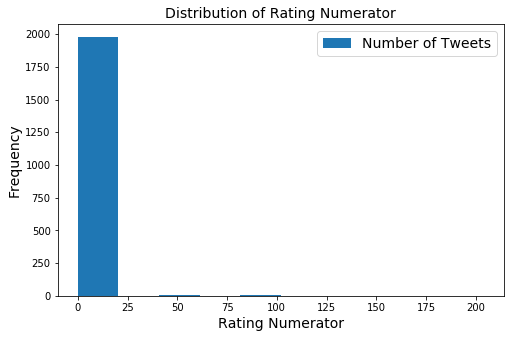

More than 1900 records have rating numerator below 250.


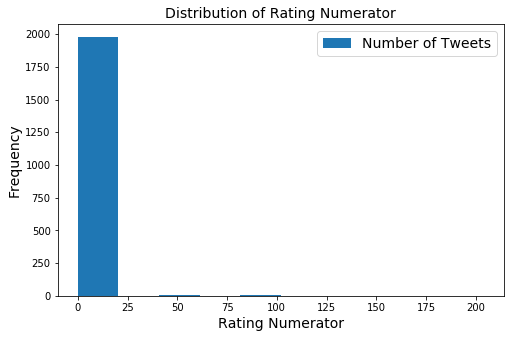

Still, more than 1900 records has rating numerator below 25.


In [46]:
# Plot the distribution of rating numerator values
twitter_archive_master.rating_numerator.plot(kind='hist',
                                             label='Number of Tweets',
                                             figsize=(8,5))

plt.legend(fontsize=14)
plt.title('Distribution of Rating Numerator', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Rating Numerator', fontsize=14)
plt.show();
print('More than 1900 records have rating numerator below 250.')

# Plot the distribution of rating numberator values again.
# This is because most records have numerator below 250.
twitter_archive_master = twitter_archive_master[twitter_archive_master.
                                                    rating_numerator < 250]
twitter_archive_master.rating_numerator.plot(kind='hist',
                                             label='Number of Tweets',
                                             figsize=(8,5))

plt.legend(fontsize=14)
plt.title('Distribution of Rating Numerator', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Rating Numerator', fontsize=14)
plt.show();
print('Still, more than 1900 records has rating numerator below 25.')


The following figure shows that there are exceptionally few records with a rating below 6.5. However; the lowest **common** rating for a dog seems to be 7. The figure also indicates that around 75% of the ratings are equal to or greater than 10. Furthermore; in most of the cases the rating denominators are 10. 


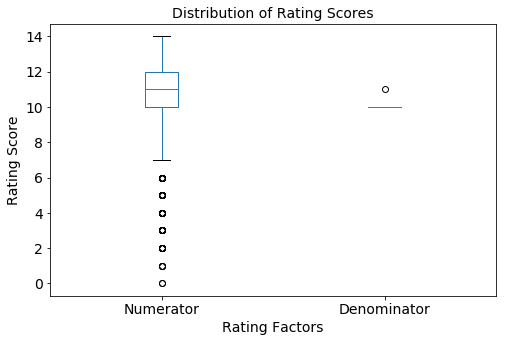

Rating numerator almost always has a value between 6.5 and 16.
Rating denominator almost always has a value 10.


In [48]:
# Get records with rating numerators below 25
twitter_archive_master = twitter_archive_master[
    twitter_archive_master.rating_numerator < 25]

# Get numerator and denominator variables only 
numerator_vs_denominator = twitter_archive_master[
    ['rating_numerator', 'rating_denominator']]

numerator_vs_denominator = numerator_vs_denominator.rename(
    columns={'rating_numerator': 'Numerator', 
             'rating_denominator': 'Denominator'})

# Plot the distribution of rating numerators below 25
numerator_vs_denominator.plot(kind='box', figsize=(8, 5))
plt.title('Distribution of Rating Scores', fontsize=14)
plt.ylabel('Rating Score', fontsize=14)
plt.xlabel('Rating Factors', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(fname='images/Distribution_of_rating_scores.png')
plt.show();
print('Rating numerator almost always has a value between 6.5 and 16.')
print('Rating denominator almost always has a value 10.')


The following figure shows that the most frequent ratings are between 10 and 13 (accumulated towards the right). In fact, around 84% of the ratings are above 10. This indicates that, ratings of WeRateDogs are more of positive.  


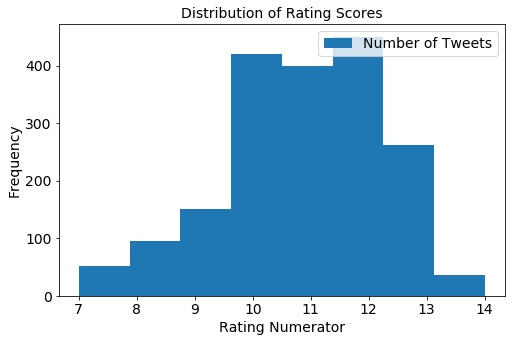

Still, 1866 records has rating numerator between 6.5 and 16.
The distribution seems left skewed. This indicates that their ratings are more positive.
This is because, 83.98% of the ratings are above 10.


In [49]:
# Plot the distribution of rating numberator values between 6.5 and 16
numerator_vs_denominator = numerator_vs_denominator[
    (numerator_vs_denominator.Numerator < 16) & 
    (numerator_vs_denominator.Numerator > 6.5)]

numerator_vs_denominator.Numerator.plot(kind='hist',
                                        bins=8, figsize=(8, 5),
                                        label='Number of Tweets')
plt.legend(fontsize=14)
plt.title('Distribution of Rating Scores', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Rating Numerator', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(fname='images/Frequency_distribution_of_rating_scores.png')
plt.show();
print('Still, {} records has rating numerator between 6.5 and 16.'.
      format(len(numerator_vs_denominator)))
print('The distribution seems left skewed. '+ 
      'This indicates that their ratings are more positive.')

# Get the proportion of tweets with rating greater than 10
percentage_above_10 = ((numerator_vs_denominator.Numerator.value_counts()/
                         len(numerator_vs_denominator))*100).sort_index()
print('This is because, {0:.2f}% of the ratings are above 10.'.
      format(percentage_above_10[10:].sum()))


<a id='research_question_2'></a>

## Which Dog Breeds are the Most Popular on WeRateDogs?

We have seen that ratings of WeRateDogs are positive, but which dog breeds are the most popular? Tweets may not contain information about the breed of a dog in the tweet. Hence; dog’s breed was predicted from its [picture in the tweet](#sample_tweet_by_WeRateDogs). As a result of this, tweets with prediction confidence greater than 85% were filtered. (371 tweets satisfy this criterion) Having said that, popularity can be defined from two perspectives.


In [50]:
# Get dog breed predictions with confidence level > 85%
confident_predictions = twitter_archive_master_copy[(
    (twitter_archive_master_copy.p1_dog == True) & 
    (twitter_archive_master_copy.p1_conf > 0.85))]

print('{} dog breed predictions have > 85% confidence level.'.
      format(len(confident_predictions)))

371 dog breed predictions have > 85% confidence level.



1. The _number of tweets_ that are posted about a certain dog breed. The figure below shows that Golden Retriever is the most tweeted dog breed. Tweets about Golden Retriever take around 14% of the total tweets. Hence; from the number of tweets perspective, Golden Retriever is the most popular dog breed on WeRateDogs.


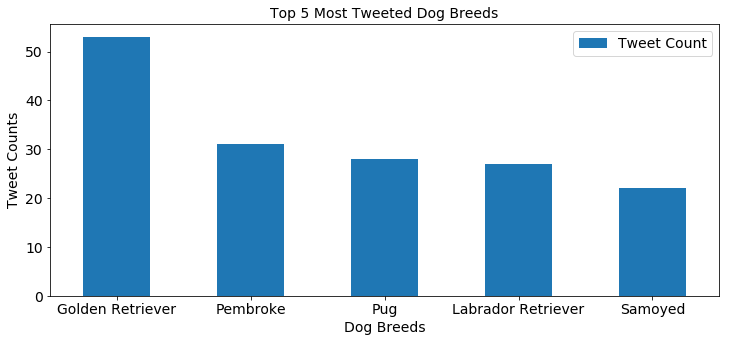

Based on number of tweets; Golden Retriever, Pembroke, Pug, Labrador Retriever, and Samoyed are the most popular.


In [52]:
# Get WeRateDogs' popular dog breed
most_tweeted_breeds = confident_predictions.groupby(
    ['p1'], as_index=False)['tweet_id'].count().sort_values(
    ascending=False, by='tweet_id')

# Get the top 5 rows
top_5_most_tweeted_breeds = most_tweeted_breeds.head(5)
top_5_most_tweeted_breeds.index = top_5_most_tweeted_breeds['p1'].str.replace(
    '_', ' ').str.title().to_list()

# Plot the top 5 most popular breeds 
top_5_most_tweeted_breeds = top_5_most_tweeted_breeds.rename(
    columns={'tweet_id': 'Tweet Count'})
top_5_most_tweeted_breeds.plot(kind='bar', figsize=(12,5), rot=0)
plt.legend(fontsize=14)
plt.title('Top 5 Most Tweeted Dog Breeds', fontsize=14)
plt.ylabel('Tweet Counts', fontsize=14)
plt.xlabel('Dog Breeds', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(fname='images/The_most_tweeted_dog_breeds.png')
plt.show();
print('Based on number of tweets; {}, {}, {}, {}, and {} are the most popular.'.
      format(*top_5_most_tweeted_breeds.index.to_list()))


2. The _number of likes_ a certain dog breed in a tweet gets. It is important to note that, this metric of popularity can be biased by the content of the tweeted text. This is because some of the tweets posted by WeRateDogs are funny, and the number of likes for a tweet may not necessarily be because of the dog in the tweet. As shown in the figure below Golden Retrievers are still the most popular breeds when considering the number of likes each breed got. The total number of likes that Golden Retrievers got is around 18% of the total likes. Hence; when considering the number of likes tweets get, tweets about Golden Retrievers are the most popular on WeRateDogs.


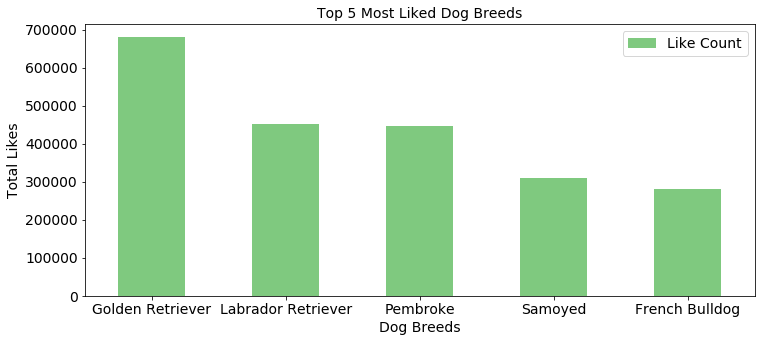

Based on favorite counts; Golden Retriever, Labrador Retriever, Pembroke, Samoyed, and French Bulldog are the most popular.


In [54]:
# Get viewers' popular dog breed
most_favorite_breeds = confident_predictions.groupby(
    ['p1'], as_index=False)['favorite_count'].sum().sort_values(
    ascending=False, by='favorite_count')

# Get the top 5 rows
top_5_most_favorite_breeds = most_favorite_breeds.head(5)
top_5_most_favorite_breeds.index = top_5_most_favorite_breeds['p1'].str.replace(
    '_', ' ').str.title().to_list()

# Plot the top 5 most popular breeds 
top_5_most_favorite_breeds = top_5_most_favorite_breeds.rename(
    columns={'favorite_count': 'Like Count'})
top_5_most_favorite_breeds.plot(kind='bar', figsize=(12,5), colormap='Accent', rot=0)
plt.title('Top 5 Most Liked Dog Breeds', fontsize=14)
plt.legend(fontsize=14)
plt.ylabel('Total Likes', fontsize=14)
plt.xlabel('Dog Breeds', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(fname='images/The_most_liked_dog_breeds.png')
plt.show();
print('Based on favorite counts; {}, {}, {}, {}, and {} are the most popular.'
      .format(*top_5_most_favorite_breeds.index.to_list()))


<a id='research_question_3'></a>

## Have the Ratings of WeRateDogs Been Consistent Through Time?

Besides being a positive rating platform, what does their ratings trend look like? This question is important because, it is important to know when this positive rating was started. If there is consistency in their ratings throughout the years, then they could be deliberately making their ratings positive.


In [56]:
# Get the original master data
twitter_archive_master = twitter_archive_master_copy

# Get rows having rating numberator values between 6.5 and 16
twitter_archive_master = twitter_archive_master[
    (twitter_archive_master.rating_numerator < 16) & 
    (twitter_archive_master.rating_numerator > 6.5)]

# Get ratings sorted by time
time_vs_rating = twitter_archive_master[
    ['timestamp', 'rating_numerator']].sort_values(by='timestamp')

# For ease of analysis, convert timestamp to date
time_vs_rating.timestamp = time_vs_rating.timestamp.dt.date

# Group data on similar days togather.
# Represent ratings of the day using their median 
time_vs_rating = time_vs_rating.groupby('timestamp').rating_numerator.median()

# Compute 30 days moving average of ratings
time_vs_rating = time_vs_rating.rolling(window=30).mean()
time_vs_rating.name = '30 Days Moving Average'
time_vs_rating.index = pd.to_datetime(time_vs_rating.index)


As the figure below shows, their ratings were continuously increasing throughout the years. Hence; the higher positive ratings do not seem random; rather, seem to be deliberate as there is consistency.


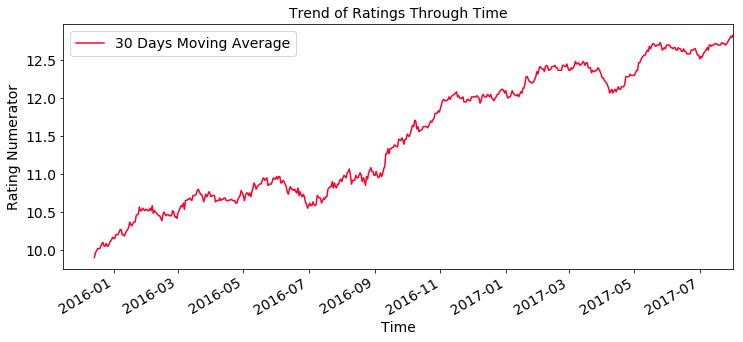

Their ratings were not just positive, but also have increased with time.


In [58]:
# Plot the time series data
time_vs_rating.plot(figsize=(12,5), colormap='gist_rainbow')
plt.legend(fontsize=14)
plt.title('Trend of Ratings Through Time', fontsize=14)
plt.ylabel('Rating Numerator', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(fname='images/Ratings_through_time.png')
plt.show();

print('Their ratings were not just positive, but also have increased with time.')


<a id='conclusion'></a>

# Conclusion

The above analysis results indicate, the secrets behind popularity of WeRateDogs. Their ratings, in most of the cases, were positive. Furthermore; the higher positive ratings seem deliberate. The other finding was about the most popular dog breed. Results show that Golden Retrievers are the most tweeted and liked dog breeds. 
